Copyright 2015-2025 Universidad Complutense de Madrid (UCM)

This file contains code adapted from Numina https://github.com/guaix-ucm/numina.

It was developed by N. Cardiel for students of the Astrophysics Master (UCM).

This is an adapted version for lectures at ULS (Chile).

* License:
SPDX-License-Identifier: GPL-3.0+

* Modified by:
C. Cabello (UCM; Spain), 
L. Costantin (CAB; Spain)

## Bias correction

### Imports

In [1]:
'''
:Settings:
conda activate uls_2025

:History:
23 Mar 25:  version 1.0
'''

import os
import ccdproc
import numpy as np
import teareduce as tea
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from pathlib import Path
from astropy.io import fits
from datetime import datetime
from tqdm.notebook import tqdm
from astropy.stats import mad_std
from astropy.nddata import CCDData
from ccdproc import ImageFileCollection
from astropy.nddata.nduncertainty import StdDevUncertainty

tea.avoid_astropy_warnings(True)

__version__ = "1.0"
__author__  = "Cristina Cabello (UCM, Spain) and Luca Costantin (CAB, Spain)"


### Read data

In [10]:
galaxy_ID = 'NGC2366'

## MODIFY THE FOLLOWING

abs_path = f'./'

dir_data = Path(f'{abs_path}/data/spectroscopy')
dir_calibration = Path(f'{abs_path}/calibration/')

#if (os.path.isdir(dir_calibration) == False):
		#os.mkdir(dir_calibration)

dir_calibration = Path(f'{abs_path}/calibration/spectroscopy')
#if (os.path.isdir(dir_calibration) == False):
		#os.mkdir(dir_calibration)

In [11]:
## Select keywords that I want to read

selected_keywords = ['NAXIS1', 'NAXIS2', 'OBJECT' ,'IMAGETYP', 'EXPTIME', 
                     'INSFLID', 'DATE-OBS']

## Read all *target* files and print the info

ifc_target = ImageFileCollection(location=f'{dir_data}',
                                glob_include='science*.fits',
                                keywords=selected_keywords)

summary_target = tea.ifc_statsummary(ifc_target, dir_data)

summary_target

  0%|          | 0/4 [00:00<?, ?it/s]

<Table length=4>
         file         NAXIS1 NAXIS2 ... percentile25 percentile75 percentile84
        str21         int64  int64  ...   float64      float64      float64   
--------------------- ------ ------ ... ------------ ------------ ------------
science_galaxy_1.fits   1431   2048 ...      685.000      704.000      709.000
science_galaxy_2.fits   1431   2048 ...      685.000      705.000      711.000
science_galaxy_3.fits   1431   2048 ...      685.000      705.000      710.000
    science_star.fits   1431   2048 ...      660.000      670.000      673.000

In [12]:
## Read all *cal* files and print the info
## We use the same keywords as for the *cal* files

ifc_cal = ImageFileCollection(location=f'{dir_data}',
                                glob_include='cali*.fits',
                                keywords=selected_keywords)

summary_cal = tea.ifc_statsummary(ifc_cal, dir_data)

matches_bias = ['bias' in object_name.lower() 
                for object_name in ifc_cal.summary['IMAGETYP']]

summary_bias = summary_cal[matches_bias]

summary_bias

  0%|          | 0/35 [00:00<?, ?it/s]

<Table length=16>
     file      NAXIS1 NAXIS2 OBJECT ... percentile25 percentile75 percentile84
    str14      int64  int64  str17  ...   float64      float64      float64   
-------------- ------ ------ ------ ... ------------ ------------ ------------
cali_0001.fits   1431   2048   bias ...      653.000      661.000      664.000
cali_0002.fits   1431   2048   bias ...      654.000      663.000      665.000
cali_0003.fits   1431   2048   bias ...      654.000      663.000      665.000
cali_0004.fits   1431   2048   bias ...      652.000      661.000      663.000
cali_0005.fits   1431   2048   bias ...      653.000      662.000      664.000
cali_0006.fits   1431   2048   bias ...      652.000      660.000      663.000
cali_0007.fits   1431   2048   bias ...      653.000      662.000      664.000
cali_0008.fits   1431   2048   bias ...      654.000      663.000      665.000
cali_0009.fits   1431   2048   bias ...      652.000      661.000      663.000
cali_0010.fits   1431   2048   bias ...      653.000      661.000      664.000
cali_0011.fits   1431   2048   bias ...      654.000      663.000      665.000
cali_0012.fits   1431   2048   bias ...      654.000      662.000      664.000
cali_0013.fits   1431   2048   bias ...      652.000      661.000      663.000
cali_0014.fits   1431   2048   bias ...      654.000      662.000      664.000
cali_0015.fits   1431   2048   bias ...      654.000      663.000      665.000
cali_0016.fits   1431   2048   bias ...      652.000      661.000      663.000

### Check bias statistics and overscan/underscan regions

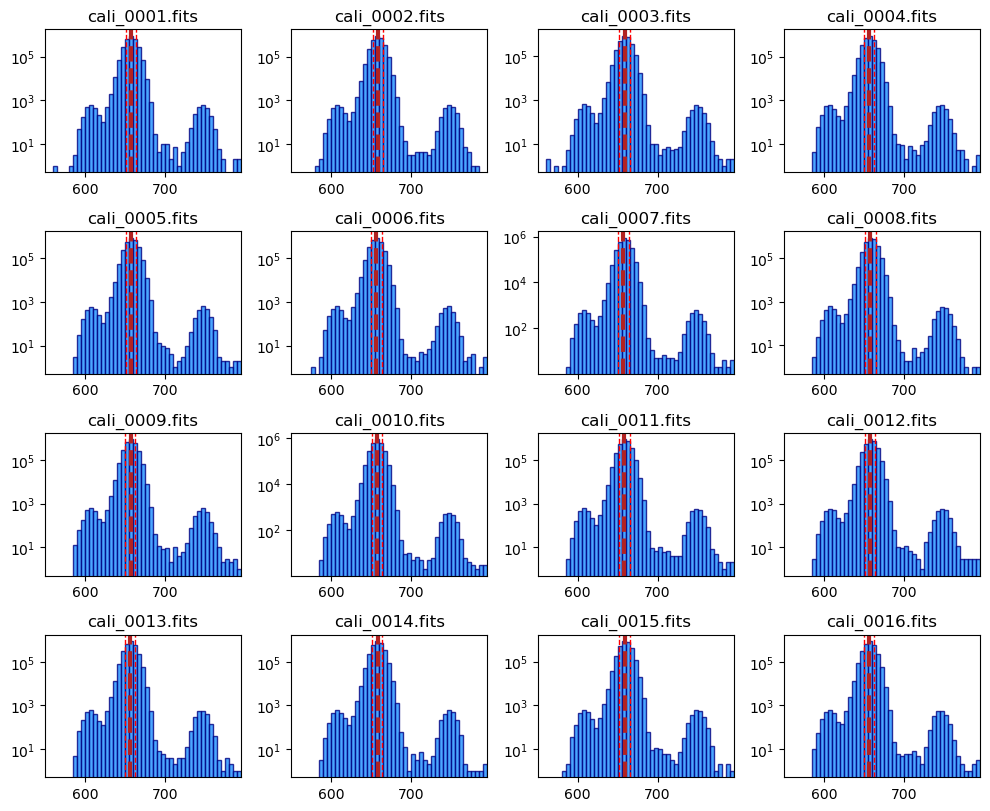

In [16]:
# define the histogram bins to be employed
bins = np.arange(550, 800, 5)

num_bias = len(summary_bias['file'])

fig = plt.figure(figsize=(10, 10))

for i in range(num_bias):

    ax = plt.subplot(5, 4, i+1)

# works in Linux and Windows
    input_file  = dir_data / Path(summary_bias['file'][i]).name
    
    bias_data   = fits.getdata(input_file)
    bias_header = fits.getheader(input_file)

    ax.hist(bias_data.flatten(), alpha=0.8, bins=bins, log=True, 
            color='dodgerblue', edgecolor='navy')
    ax.axvline(summary_bias['percentile16'][i], color='red', 
               linestyle='--', linewidth=1)
    ax.axvline(summary_bias['median'][i], color='firebrick', 
               linestyle='--', linewidth=3)
    ax.axvline(summary_bias['percentile84'][i], color='red', 
               linestyle='--', linewidth=1)
    ax.set_title(bias_header['FILENAME'])
    ax.set_xlim(min(bins), max(bins))
    
plt.tight_layout()

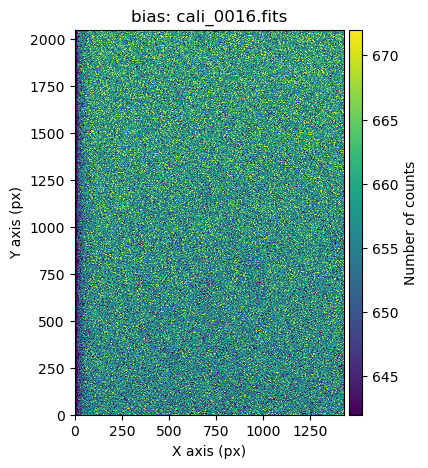

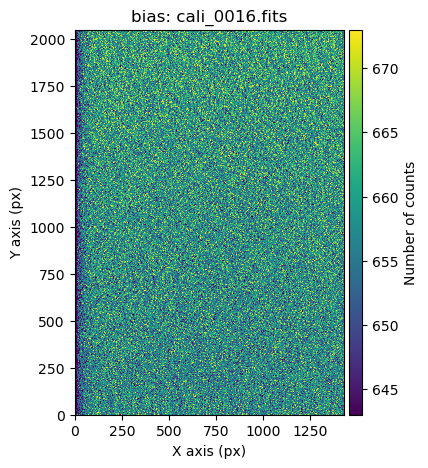

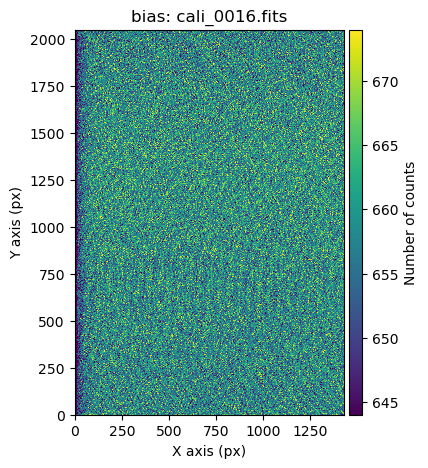

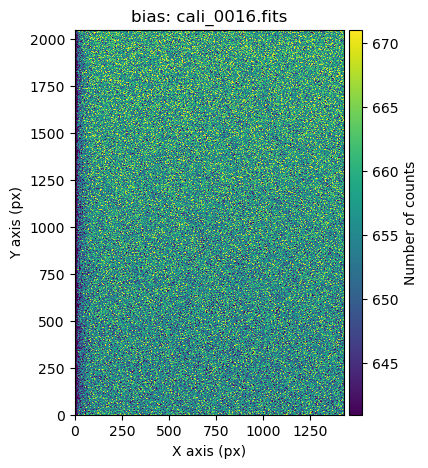

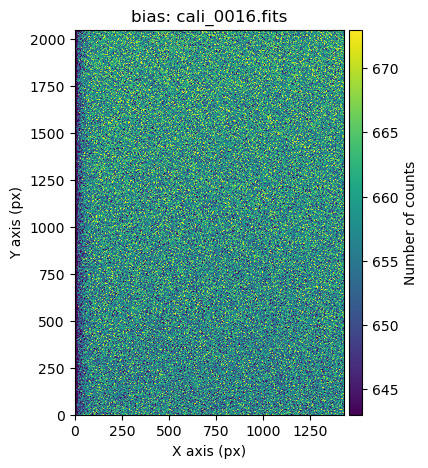

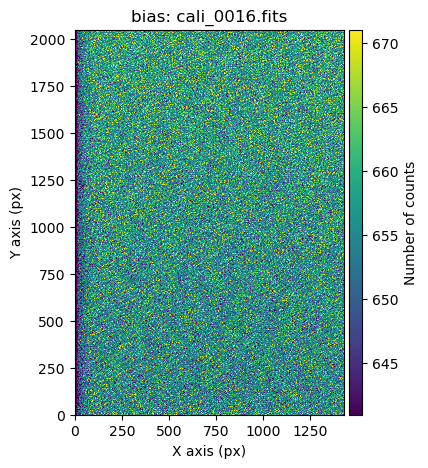

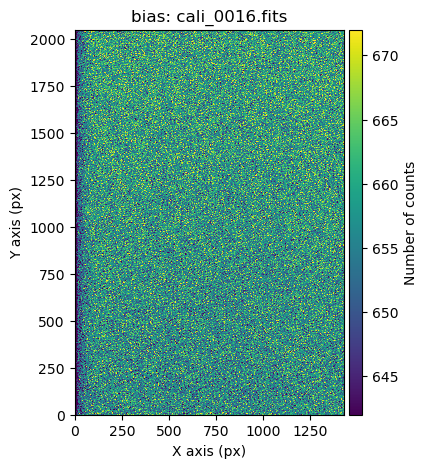

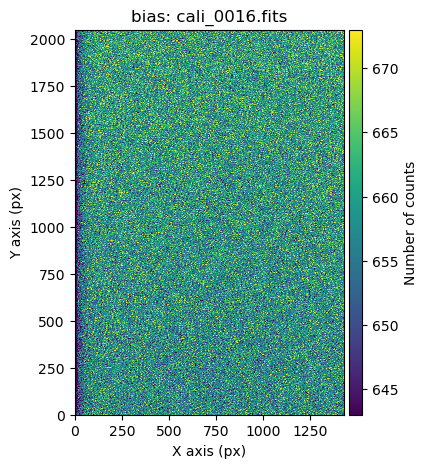

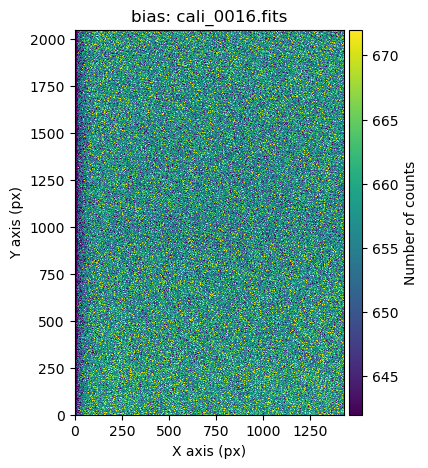

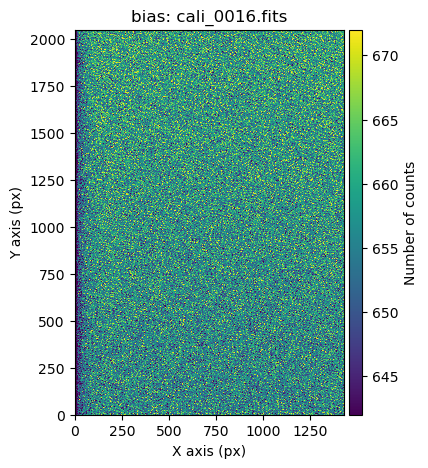

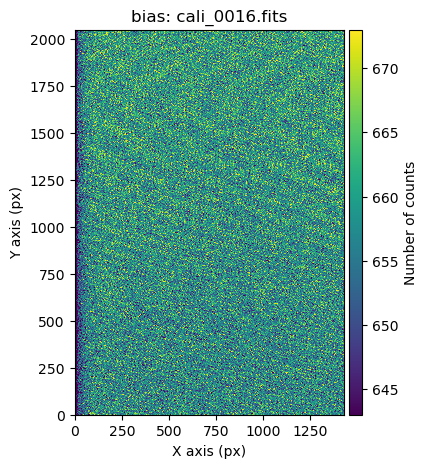

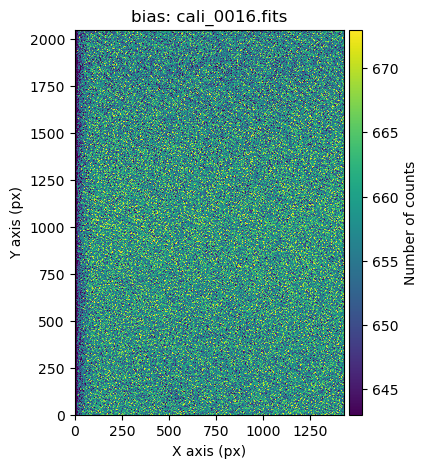

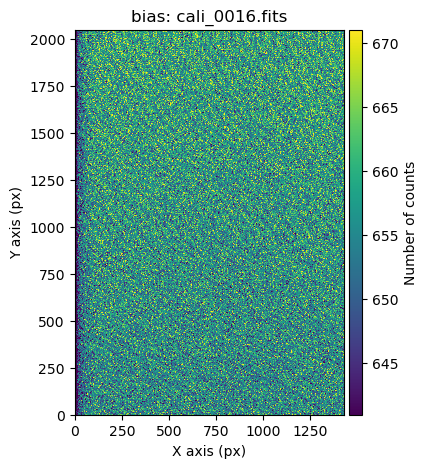

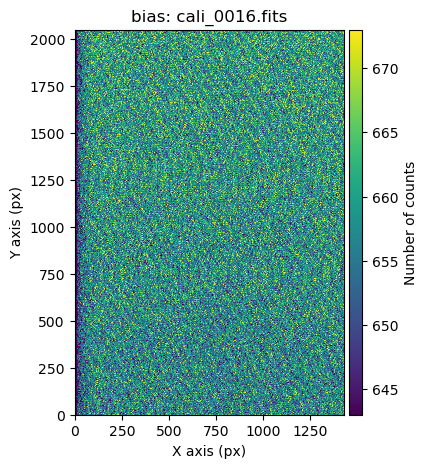

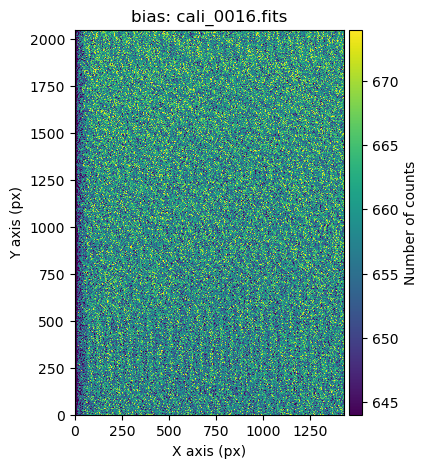

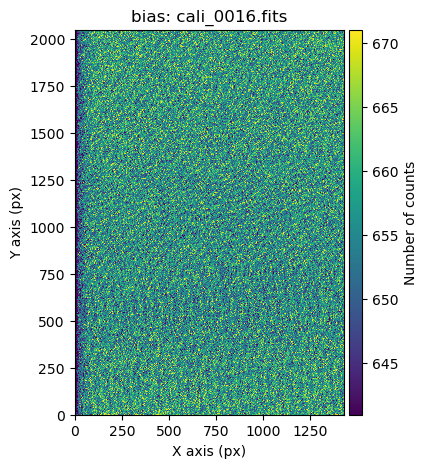

In [17]:
## Show all frames or just the first one
show_all = True

for filename in summary_bias['file']:

    data = fits.getdata(dir_data / filename)
    vmin = np.median(data) - 15
    vmax = np.median(data) + 15
    
    if (show_all == True):
        fig, ax = plt.subplots(figsize=(15, 5))
        tea.imshow(fig, ax, data, vmin=vmin, vmax=vmax)
        str_plot_title = summary_bias['file'][i]
        ax.set_xlabel('X axis (px)')
        ax.set_ylabel('Y axis (px)')
        ax.set_title(f'bias: {str_plot_title}')
        plt.show()

    else:
        fig, ax = plt.subplots(figsize=(15, 5))
        tea.imshow(fig, ax, data, vmin=vmin, vmax=vmax)
        str_plot_title = summary_bias['file'][i]
        ax.set_xlabel('X axis (px)')
        ax.set_ylabel('Y axis (px)')
        ax.set_title(f'bias: {str_plot_title}')        
        plt.show()
        break


In [18]:
## Define a function to check the bias level in different exposures

def plot_bias_frames(region_underscan, 
                     region_overscan, 
                     subtract_underoverscan=False):
    
    fig = plt.figure(figsize=(10, 8))
    ax1 = plt.subplot(2, 1, 1)
    ax2 = plt.subplot(2, 2, 3)
    ax3 = plt.subplot(2, 2, 4)

    ymin, ymax = 650, 675

    for filename in summary_bias['file']:
        data = fits.getdata(dir_data / filename)
        if subtract_underoverscan:
            # regions are given following FITS convention
            med_underscan = np.median(data[region_underscan.python])
            med_overscan = np.median(data[region_overscan.python])
            print(f'{filename}: underscan: {med_underscan}, overscan: {med_overscan}')
            med_underoverscan = (med_underscan + med_overscan) / 2
            data = data - med_underoverscan
            ymin_ = ymin - med_underoverscan
            ymax_ = ymax - med_underoverscan
        else:
            ymin_ = ymin
            ymax_ = ymax
        naxis2, naxis1 = data.shape
        xplot = np.arange(naxis1)
        for ax in [ax1, ax2, ax3]:
            ax.plot(xplot, np.median(data, axis=0), lw=1, label=filename)
    ax1.set_title('BIAS comparison')

    for ax in [ax1, ax2, ax3]:
        ax.set_ylim([ymin_, ymax_])
        ax.set_xlabel('X axis (px)')
        ax.set_ylabel('Number of counts')

    x1_underscan = region_underscan.python[1].start
    x2_underscan = region_underscan.python[1].stop
    ax2.set_xlim([x1_underscan - 5, x2_underscan + 50])
    
    x1_overscan = region_overscan.python[1].start
    x2_overscan = region_overscan.python[1].stop
    ax3.set_xlim([x1_overscan - 50, x2_overscan + 5])

    rect_underscan = patches.Rectangle(
        xy=(x1_underscan, ymin_), 
        width=x2_underscan - x1_underscan, 
        height=ymax_ - ymin_, 
        color='C0', alpha=0.2
    )
    rect_overscan = patches.Rectangle(
        xy=(x1_overscan, ymin_), 
        width=x2_overscan - x1_overscan, 
        height=ymax_-ymin_, 
        color='C0', alpha=0.2
    )

    ax2.add_patch(rect_underscan)
    ax3.add_patch(rect_overscan)

    ax1.legend(ncol=5)

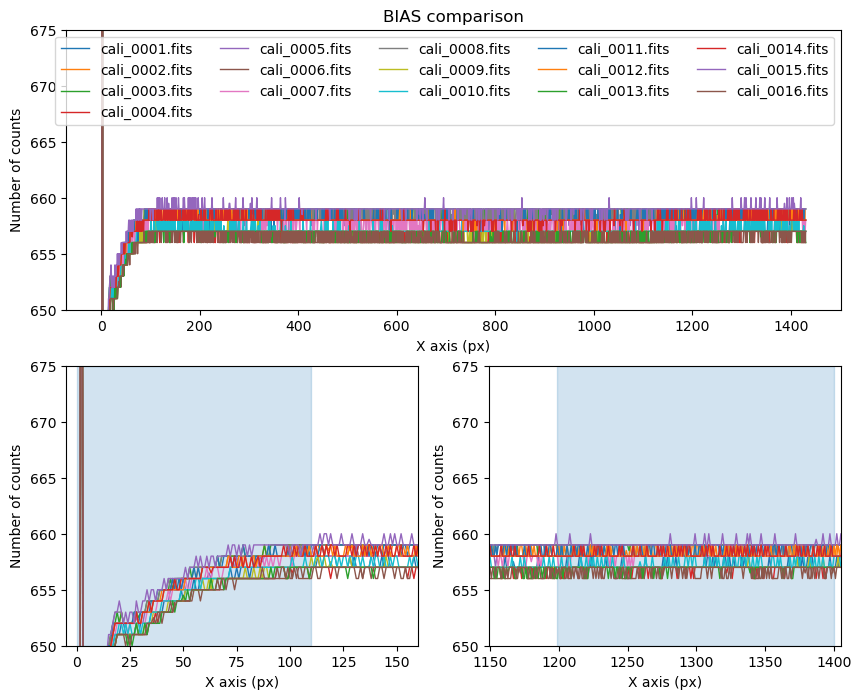

In [19]:
plot_bias_frames(
    region_underscan=tea.SliceRegion2D(np.s_[1:110, 1:2048], mode='fits'),
    region_overscan=tea.SliceRegion2D(np.s_[1200:1400, 1:2048], mode='fits'),
    subtract_underoverscan=False)

Check that all files have the same shape, just in case the window was different during the acquisition.

In [20]:
for filename in summary_bias['file']:
    data = fits.getdata(dir_data / filename)
    print(f'{filename}: {data.shape}')

cali_0001.fits: (2048, 1431)
cali_0002.fits: (2048, 1431)
cali_0003.fits: (2048, 1431)
cali_0004.fits: (2048, 1431)
cali_0005.fits: (2048, 1431)
cali_0006.fits: (2048, 1431)
cali_0007.fits: (2048, 1431)
cali_0008.fits: (2048, 1431)
cali_0009.fits: (2048, 1431)
cali_0010.fits: (2048, 1431)
cali_0011.fits: (2048, 1431)
cali_0012.fits: (2048, 1431)
cali_0013.fits: (2048, 1431)
cali_0014.fits: (2048, 1431)
cali_0015.fits: (2048, 1431)
cali_0016.fits: (2048, 1431)


In [21]:
naxis2 = data.shape[0]  # y direction (spectral direction)
naxis1 = data.shape[1]  # x direction (spatial direction)

Slice frames across x and y directions and inspect the number of counts.

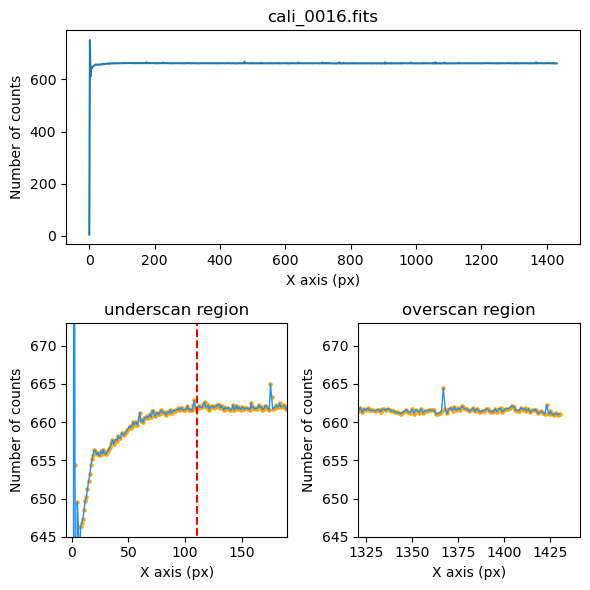

In [35]:
## MODIFY THE FOLLOWING: trim_line_1, trim_line_2

trim_line_1 = 110
trim_line_2 = 1300

xplot = np.arange(naxis1)
yplot = np.mean(data, axis=0)

fig = plt.figure(figsize=(6, 6))

for i in range(3):
    if i == 0:
        ax = plt.subplot(2, 1, 1)
        ax.set_title(str_plot_title)
    elif i == 1:
        ax = plt.subplot(2, 2, 3)
        ax.set_title('underscan region')
    else:
        ax = plt.subplot(2, 2, 4)
        ax.set_title('overscan region')
    if i == 0:
        ax.plot(xplot, yplot)
    else:
        ax.scatter(xplot, yplot, marker='o', s=5, color='orange')
        ax.plot(xplot, yplot, linestyle='-', lw=1, color='dodgerblue')
    if i == 1:
        ax.set_xlim([-5, 190])
        ax.plot([trim_line_1,trim_line_1], [min(yplot), max(yplot)], 
                linestyle='--', color='red')
    elif i == 2:
        ax.set_xlim([naxis1-110, naxis1+10])
        ax.plot([trim_line_2,trim_line_2], [min(yplot), max(yplot)], 
                linestyle='--', color='red')
    if i != 0:
        ax.set_ylim([645, 673])
    ax.set_xlabel('X axis (px)')
    ax.set_ylabel('Number of counts')
    
plt.tight_layout()

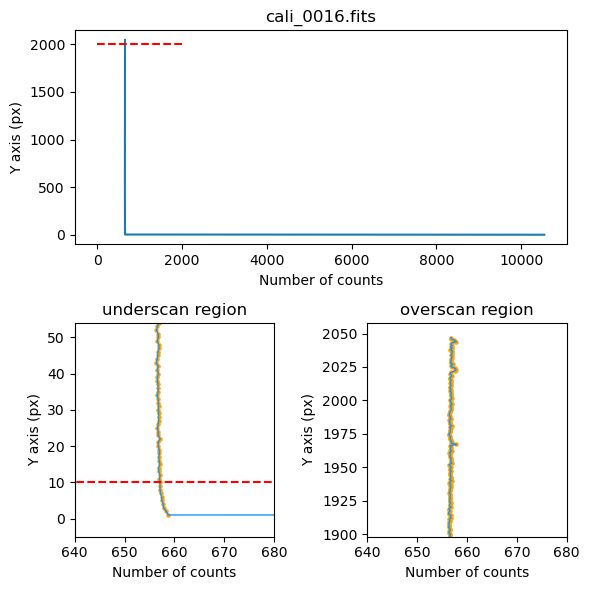

In [38]:
## MODIFY THE FOLLOWING: trim_line_1, trim_line_2

trim_line_1 = 10
trim_line_2 = 2000

yplot = np.arange(naxis2)
xplot = np.mean(data, axis=1)

fig = plt.figure(figsize=(6, 6))

for i in range(3):
    if i == 0:
        ax = plt.subplot(2, 1, 1)
        ax.set_title(str_plot_title)
        ax.plot(xplot, yplot)
        ax.set_ylim([0, naxis2+10])
    elif i == 1:
        ax = plt.subplot(2, 2, 3)
        ax.set_title('underscan region')
    else:
        ax = plt.subplot(2, 2, 4)
        ax.set_title('overscan region')
    if i == 0:
        pass
    else:
        ax.scatter(xplot, yplot, marker='o', s=5, color='orange')
        ax.plot(xplot, yplot, linestyle='-', lw=1, color='dodgerblue')
    if i == 1:
        ax.set_ylim([-5, 54])
        ax.set_xlim([640, 680])
        ax.plot([min(yplot), max(yplot)], [trim_line_1,trim_line_1], 
                linestyle='--', color='red')
    elif i == 0:
        ax.set_ylim([-100, naxis2+100])
        ax.plot([min(yplot), max(yplot)], [trim_line_2,trim_line_2], 
                linestyle='--', color='red')
    else:
        ax.set_ylim([naxis2-150, naxis2+10])
        ax.set_xlim([640, 680])
    ax.set_ylabel('Y axis (px)')
    ax.set_xlabel('Number of counts')
    
plt.tight_layout()

Check also domeflat files, since from visual inspection we can see a saturated feature which extends across the detector.

In [24]:
matches_flat = ['flat' in object_name.lower() 
                for object_name in ifc_cal.summary['IMAGETYP']]

summary_flat = summary_cal[matches_flat]

summary_flat

<Table length=16>
     file      NAXIS1 NAXIS2 OBJECT ... percentile25 percentile75 percentile84
    str14      int64  int64  str17  ...   float64      float64      float64   
-------------- ------ ------ ------ ... ------------ ------------ ------------
cali_0017.fits   1431   2048   flat ...     6650.000    30717.000    32754.000
cali_0018.fits   1431   2048   flat ...     6670.000    30835.000    32891.000
cali_0019.fits   1431   2048   flat ...     6729.000    31078.000    33149.000
cali_0020.fits   1431   2048   flat ...     6714.000    30999.000    33065.000
cali_0021.fits   1431   2048   flat ...     6723.000    31071.000    33147.000
cali_0022.fits   1431   2048   flat ...     6614.000    30670.000    32731.000
cali_0023.fits   1431   2048   flat ...     6683.000    30920.000    32990.000
cali_0024.fits   1431   2048   flat ...     6657.000    30837.000    32904.000
cali_0025.fits   1431   2048   flat ...     6574.000    30520.000    32577.000
cali_0026.fits   1431   2048   flat ...     6588.000    30574.000    32629.000
cali_0027.fits   1431   2048   flat ...     6537.000    30404.000    32455.000
cali_0028.fits   1431   2048   flat ...     6750.000    31167.000    33245.000
cali_0029.fits   1431   2048   flat ...     6777.000    31257.000    33341.000
cali_0030.fits   1431   2048   flat ...     6739.000    31140.000    33219.000
cali_0031.fits   1431   2048   flat ...     7015.000    32120.000    34238.000
cali_0032.fits   1431   2048   flat ...     7052.000    32252.000    34375.000

In [25]:
for filename in summary_flat['file']:
    data_flat = fits.getdata(dir_data / filename)
    print(f'{filename}: {data.shape}')

cali_0017.fits: (2048, 1431)
cali_0018.fits: (2048, 1431)
cali_0019.fits: (2048, 1431)
cali_0020.fits: (2048, 1431)
cali_0021.fits: (2048, 1431)
cali_0022.fits: (2048, 1431)
cali_0023.fits: (2048, 1431)
cali_0024.fits: (2048, 1431)
cali_0025.fits: (2048, 1431)
cali_0026.fits: (2048, 1431)
cali_0027.fits: (2048, 1431)
cali_0028.fits: (2048, 1431)
cali_0029.fits: (2048, 1431)
cali_0030.fits: (2048, 1431)
cali_0031.fits: (2048, 1431)
cali_0032.fits: (2048, 1431)


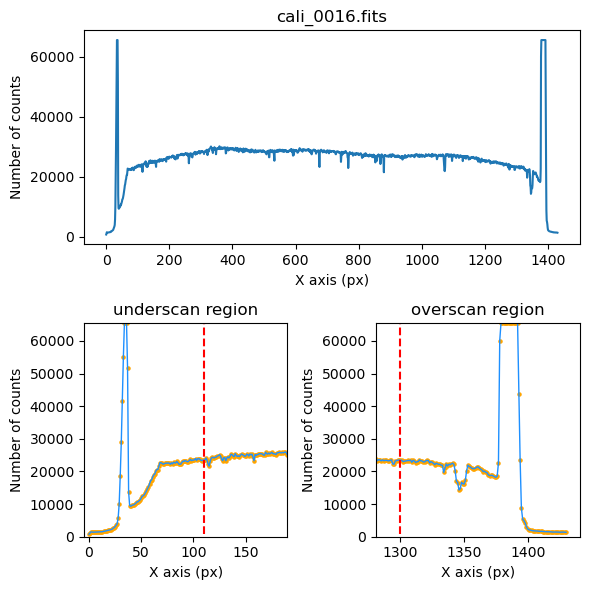

In [36]:
## MODIFY THE FOLLOWING: trim_line_1, trim_line_2

trim_line_1 = 110
trim_line_2 = 1300

xplot = np.arange(naxis1)
yplot = data_flat[1000,:]

fig = plt.figure(figsize=(6, 6))

for i in range(3):
    if i == 0:
        ax = plt.subplot(2, 1, 1)
        ax.set_title(str_plot_title)
    elif i == 1:
        ax = plt.subplot(2, 2, 3)
        ax.set_title('underscan region')
    else:
        ax = plt.subplot(2, 2, 4)
        ax.set_title('overscan region')
    if i == 0:
        ax.plot(xplot, yplot)
    else:
        ax.scatter(xplot, yplot, marker='o', s=5, color='orange')
        ax.plot(xplot, yplot, linestyle='-', lw=1, color='dodgerblue')
    if i == 1:
        ax.set_xlim([-5, 190])
        ax.plot([trim_line_1,trim_line_1], [min(yplot), max(yplot)], 
                linestyle='--', color='red')
    elif i == 2:
        ax.set_xlim([naxis1-150, naxis1+10])
        ax.plot([trim_line_2,trim_line_2], [min(yplot), max(yplot)], 
                linestyle='--', color='red')
    if i != 0:
        ax.set_ylim([0, max(yplot)])
    ax.set_xlabel('X axis (px)')
    ax.set_ylabel('Number of counts')
    
plt.tight_layout()

### Trim all images

Importantly, any time we save/update and image we also update the HISTORY in the header to keep track of all changes.

We saved all trimmed images with the **t_** (i.e., trimmed) nomenclature.

Underscan region in x=[0:0]+[1431:1431] y=[0:0]+[2048:2048]

In [39]:
## MODIFY THE FOLLOWING

## FITS-style
fits_section = f'[110:1300, 10:2048]'

## Trim *cal* files

for filename in summary_cal['file']:
    
    image   = CCDData.read(f'{dir_data}/{filename}', hdu=0, unit='adu')
    t_image = ccdproc.trim_image(image, fits_section=fits_section)

    output_filename = f't_{filename}'

    t_image.header['FILENAME']  = output_filename
    t_image.header['HISTORY']  = '-------------------'
    t_image.header['HISTORY']  = f"{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}"
    t_image.header['HISTORY']  = f'fits_section={fits_section}' 
    t_image.header['HISTORY']  = 'using ccdproc.trim_image'
    t_image.write(f'{dir_calibration}/{output_filename}', overwrite='yes', format='fits')

## Trim *science* files

for filename in summary_target['file']:
    
    image   = CCDData.read(f'{dir_data}/{filename}', hdu=0, unit='adu')
    t_image = ccdproc.trim_image(image, fits_section=fits_section)

    output_filename = f't_{filename}'

    t_image.header['FILENAME']  = output_filename
    t_image.header['HISTORY']  = '-------------------'
    t_image.header['HISTORY']  = f"{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}"
    t_image.header['HISTORY']  = f'fits_section={fits_section}' 
    t_image.header['HISTORY']  = 'using ccdproc.trim_image'
    t_image.write(f'{dir_calibration}/{output_filename}', overwrite='yes', format='fits')



### Masterbias

Combine all bias frames to create a masterbias that will be subtract from all images.

In [40]:
## Read all images (cal + target) again to selected t_*

selected_keywords = ['NAXIS1', 'NAXIS2', 'OBJECT' ,'IMAGETYP', 'EXPTIME', 
                     'INSFLID', 'DATE-OBS', 'FILTER']

ifc_all = ImageFileCollection(location=f'{dir_calibration}',
                                glob_include='t_*.fits',
                                keywords=selected_keywords)

summary_all = tea.ifc_statsummary(ifc_all, dir_calibration)

matches_bias = ['bias' in object_name.lower() 
                for object_name in ifc_all.summary['OBJECT']]

summary_bias = summary_all[matches_bias]

summary_bias

  0%|          | 0/39 [00:00<?, ?it/s]

<Table length=16>
      file       NAXIS1 NAXIS2 OBJECT ... percentile25 percentile75 percentile84
     str23       int64  int64  str17  ...   float64      float64      float64   
---------------- ------ ------ ------ ... ------------ ------------ ------------
t_cali_0001.fits   1191   2039   bias ...      653.000      662.000      664.000
t_cali_0002.fits   1191   2039   bias ...      654.000      663.000      665.000
t_cali_0003.fits   1191   2039   bias ...      654.000      663.000      665.000
t_cali_0004.fits   1191   2039   bias ...      652.000      661.000      663.000
t_cali_0005.fits   1191   2039   bias ...      654.000      662.000      664.000
t_cali_0006.fits   1191   2039   bias ...      652.000      661.000      663.000
t_cali_0007.fits   1191   2039   bias ...      653.000      662.000      664.000
t_cali_0008.fits   1191   2039   bias ...      654.000      663.000      665.000
t_cali_0009.fits   1191   2039   bias ...      653.000      661.000      664.000
t_cali_0010.fits   1191   2039   bias ...      653.000      662.000      664.000
t_cali_0011.fits   1191   2039   bias ...      654.000      663.000      665.000
t_cali_0012.fits   1191   2039   bias ...      654.000      662.000      664.000
t_cali_0013.fits   1191   2039   bias ...      652.000      661.000      663.000
t_cali_0014.fits   1191   2039   bias ...      654.000      662.000      664.000
t_cali_0015.fits   1191   2039   bias ...      655.000      663.000      665.000
t_cali_0016.fits   1191   2039   bias ...      652.000      661.000      663.000

In [41]:
list_bias = []

for filename in summary_bias['file']:
    list_bias.append(CCDData.read(dir_calibration / filename))

Combine frames.

It would be useful to try the following setups and compare the results:

* Combine with average without sigma clipping;

* Combine with average and sigma clipping;

* Combine with median without sigma clipping;

* Combine with median and sigma clipping;


In [55]:
## MODIFY THE FOLLOWING

master_bias = ccdproc.combine(img_list=list_bias,
                              method='median',             # average, median
                              sigma_clip=True,             # True, False
                              sigma_clip_low_thres=6, 
                              sigma_clip_high_thresh=6,
                              sigma_clip_func=np.ma.median, 
                              sigma_clip_dev_func=mad_std)

In [53]:
_ = tea.statsummary(master_bias.data)

>>> =============================================
>>> STATISTICAL SUMMARY:
>>> ---------------------------------------------
>>> Number of points.........: 2428449
>>> Minimum..................: 645.0
>>> 1st Quartile.............: 655.0
>>> Median...................: 656.5
>>> Mean.....................: 656.5623397897176
>>> 3rd Quartile.............: 658.0
>>> Maximum..................: 706.5
>>> ---------------------------------------------
>>> Standard deviation.......: 2.291226939511338
>>> Robust standard deviation: 2.2239
>>> 0.1586553 percentile.....: 654.0
>>> 0.8413447 percentile.....: 659.0
>>> =============================================


In [56]:
# Replace FILENAME keyword and include additional information
filename_master_bias = f'master_bias.fits'
master_bias.header['FILENAME'] = filename_master_bias
master_bias.header['HISTORY']  = '-------------------'
master_bias.header['HISTORY']  = f"{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}"
master_bias.header['HISTORY']  = f'master BIAS combining {num_bias} BIAS images'
master_bias.header['HISTORY']  = 'using ccdproc.combine, with average and sigma clipping'

for ccdimage in list_bias:
    master_bias.header['HISTORY'] = f"+ {ccdimage.header['FILENAME']}"

# save result
master_bias.write(dir_calibration / filename_master_bias, overwrite='yes')

### Correct trimmed images by masterbias

Correct frames and rotate them by 90 degrees so that the spectral direction is along the y axis.

In [57]:
gain = master_bias.header['CCDGAIN']
print(f'Gain: {gain} e-/ADU')

median_bias = np.median(master_bias.data)
print(f'Median value in master BIAS: {median_bias:.2f} {master_bias.unit}')

# use mean of robust_std as Readout Noise
readout_noise = np.mean(summary_bias['robust_std'])
print(f'Readout Noise: {readout_noise:.2f} adu')

Gain: 20.0 e-/ADU
Median value in master BIAS: 657.50 adu
Readout Noise: 6.44 adu


In [58]:
for filename in tqdm(summary_all['file']):
    
    filepath = dir_calibration / filename
    
    # read data and header from file
    data = fits.getdata(filepath)
    header = fits.getheader(filepath)
    
    # create associated uncertainty from first principles
    uncertainty1 = (data - median_bias) / gain
    uncertainty1[uncertainty1 < 0] = 0.0   # remove unrealistic negative estimates
    uncertainty2 = readout_noise**2
    uncertainty = np.sqrt(uncertainty1 + uncertainty2)
    
    # create CCDData instance
    ccdimage = CCDData(data=data, 
                       header=header,
                       uncertainty=StdDevUncertainty(uncertainty),
                       unit='adu')
    
    # subtract master_bias
    ccdimage_bias_subtracted = ccdproc.subtract_bias(ccdimage, master_bias)
    
    # rotate primary HDU and extensions
    ccdimage_bias_subtracted.data = np.rot90(ccdimage_bias_subtracted.data, 3)
    ccdimage_bias_subtracted.mask = np.rot90(ccdimage_bias_subtracted.mask, 3)
    ccdimage_bias_subtracted.uncertainty.array = np.rot90(ccdimage_bias_subtracted.uncertainty.array, 3)
    # update HISTORY in header
    ccdimage_bias_subtracted.header['HISTORY'] = '-------------------'
    ccdimage_bias_subtracted.header['HISTORY'] = f"{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}"
    ccdimage_bias_subtracted.header['HISTORY'] = 'rotating image using np.rot90(array, 3)'
    
    # update FILENAME keyword with output file name
    output_filename = f'z{filename}'
    ccdimage_bias_subtracted.header['FILENAME'] = output_filename
    # update HISTORY in header
    ccdimage_bias_subtracted.header['HISTORY'] = '-------------------'
    ccdimage_bias_subtracted.header['HISTORY'] = f"{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}"
    ccdimage_bias_subtracted.header['HISTORY'] = 'using ccdproc.subtract_bias'
    ccdimage_bias_subtracted.header['HISTORY'] = f'master BIAS file: {filename_master_bias}'
    
    # save result
    ccdimage_bias_subtracted.write(dir_calibration / output_filename, overwrite='yes')

  0%|          | 0/39 [00:00<?, ?it/s]